# Clustering methods for high dimensional data

Clustering can be a very useful method for understanding the data...

__What clustering methods are available for high dimensional data__

The sofifa dataset curated by scraping the website is very rich. For each player there are 34 playing attributes which describe the playing style of the player. I wish to apply unsupervised learning techniques to see if we can derive insight about different types of players and playing styles.

This notebook will explore different methods for clustering high-dimensional data points.

------------------

## Resources

TowardsDataScience - [How to cluster in High Dimensions](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=13&cad=rja&uact=8&ved=2ahUKEwjo8eLD4onkAhUBDuwKHWgoCFsQFjAMegQIBRAB&url=https%3A%2F%2Ftowardsdatascience.com%2Fhow-to-cluster-in-high-dimensions-4ef693bacc6&usg=AOvVaw2LSr26u7GEjGXGVzvnTR2Z)  
Research paper - [SubspaceClusteringforHighDimensionalData:A Review](https://www.kdd.org/exploration_files/parsons.pdf)  
Research paper - [Feature Selection for Unsupervised Learning](http://www.jmlr.org/papers/volume5/dy04a/dy04a.pdf)    
TowardsDataScience - [Feature Selection - Correlation and p-values](https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf)

## Table of contents

----------------

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from const import ATTRIBUTES #list of attributes
pd.set_option('display.max_columns', 500) # show all dataframe columns

---------
## Load and pre-process  the data

For this analysis I will limit the data to just the playing attributes (e.g. Crossing, Finishing, Passing etc.). This will leave us with 34 features and 21,009 datapoints for the cluster analysis.

I will produce scaled and unscaled versions of the dataset....

EXPLAIN SCALING AND DIFFERENT OPTIONS
- Z-normalisation
- min-max scaling


In [3]:
raw_df = pd.read_csv("data/1. processed/data_clean.csv")

In [4]:
df = raw_df[ATTRIBUTES]
positions = raw_df['Position']
df = df.astype('float64')
print(df.shape)
df.head()

(13758, 34)


Crossing  Finishing  Heading Accuracy  Short Passing  Volleys  Dribbling  \
0      47.0       39.0              71.0           72.0     21.0       59.0   
1      60.0       65.0              64.0           76.0     68.0       77.0   
2      41.0       43.0              74.0           73.0     43.0       68.0   
3      18.0       19.0              17.0           25.0     15.0       14.0   
4      72.0       69.0              54.0           90.0     90.0       90.0   

   Curve  FK Accuracy  Long Passing  Ball Control  Acceleration  Sprint Speed  \
0   32.0         28.0          66.0          64.0          73.0          85.0   
1   59.0         68.0          70.0          77.0          79.0          77.0   
2   41.0         47.0          53.0          73.0          71.0          71.0   
3   22.0         18.0          29.0          25.0          49.0          54.0   
4   85.0         77.0          87.0          90.0          78.0          69.0   

   Agility  Reactions  Balance  Shot Power  Jumping  Stamina  Strength  \
0     61.0       67.0     62.0        44.0     86.0     61.0      88.0   
1     76.0       72.0     90.0        85.0     79.0     86.0      76.0   
2     72.0       73.0     72.0        56.0     72.0     65.0      71.0   
3     69.0       65.0     65.0        25.0     75.0     39.0      51.0   
4     90.0       86.0     86.0        76.0     75.0     75.0      59.0   

   Long Shots  Aggression  Interceptions  Positioning  Vision  Penalties  \
0        24.0        81.0           75.0         35.0    56.0       39.0   
1        77.0        90.0           69.0         70.0    67.0       68.0   
2        39.0        61.0           74.0         46.0    52.0       47.0   
3        20.0        23.0           17.0         15.0    66.0       23.0   
4        79.0        56.0           78.0         79.0    86.0       75.0   

   Composure  Marking  Standing Tackle  Sliding Tackle  GK Diving  \
0       68.0     68.0             84.0            75.0        6.0   
1       68.0     73.0             70.0            64.0        5.0   
2       57.0     73.0             76.0            72.0        8.0   
3       45.0     25.0             16.0            21.0       73.0   
4       85.0     67.0             67.0            71.0        6.0   

   GK Handling  GK Kicking  GK Positioning  GK Reflexes  
0          7.0         8.0            15.0          9.0  
1         12.0         6.0            13.0         14.0  
2         15.0         7.0            14.0          9.0  
3         70.0        69.0            74.0         77.0  
4         11.0         7.0             9.0         13.0

__Ground Truth__

In [33]:
unique_positions = raw_df['Position'].unique()[:-1]
unique_positions

array(['LCB', 'CM', 'CB', 'GK', 'LW', 'RB', 'CAM', 'RM', 'CDM', 'LM',
       'RCB', 'RS', 'ST', 'RCM', 'LCM', 'RDM', 'LDM', 'LWB', 'LB', 'RWB',
       'LS', 'RW', 'CF', 'RAM', 'LF', 'LAM', 'RF'], dtype=object)

In [61]:
def bucket_positions(x):
    
    attack = ['CF','RF','LF','ST','LS','RS']
    midfield = ['CM', 'CAM', 'RM', 'CDM', 'LM', 'RCM', 'LCM', 'RDM', 'LDM', 'RAM', 'LAM','LW','RW']
    defence = ['LCB', 'CB', 'RB', 'RCB', 'LWB', 'LB', 'RWB']
    goal_keeper = ['GK']
    
    
    if x in attack:
        return 'attack'
    elif x in midfield:
        return 'midfield'
    elif x in defence:
        return 'defence'
    elif x in goal_keeper:
        return 'goal-keeper'
    else:
        return 'nan'

In [62]:
attack = ['CF','RF','LF','ST','LS','RS']
midfield = ['CM', 'CAM', 'RM', 'CDM', 'LM', 'RCM', 'LCM', 'RDM', 'LDM', 'RAM', 'LAM']
defence = ['LCB', 'CB', 'RB', 'RCB', 'LWB', 'LB', 'RWB']

all = attack+midfield+defence

In [63]:
ground_truth_colors = {'attack':'blue','defence':'green','midfield':'red','goal-keeper':'black','nan':'yellow'}

In [64]:
labels = raw_df['Position'].apply(bucket_positions)

#### Scaling

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

__z-normalisation__

In [6]:
scaler = StandardScaler()
df_z = scaler.fit_transform(df)

In [7]:
#show new dataframe statistics
df_z = pd.DataFrame(df_z,columns=ATTRIBUTES)
df_z.describe()

Crossing     Finishing  Heading Accuracy  Short Passing  \
count  1.375800e+04  1.375800e+04      1.375800e+04   1.375800e+04   
mean   7.487436e-16 -1.048498e-15     -8.050973e-16  -3.078194e-15   
std    1.000036e+00  1.000036e+00      1.000036e+00   1.000036e+00   
min   -2.494772e+00 -2.328478e+00     -2.879126e+00  -3.758766e+00   
25%   -6.373387e-01 -7.949766e-01     -4.471374e-01  -3.226608e-01   
50%    2.367476e-01  2.273575e-01      1.898121e-01   2.383360e-01   
75%    7.284211e-01  7.896413e-01      6.530481e-01   6.590835e-01   
max    2.258072e+00  2.425376e+00      2.332279e+00   2.271949e+00   

            Volleys     Dribbling         Curve   FK Accuracy  Long Passing  \
count  1.375800e+04  1.375800e+04  1.375800e+04  1.375800e+04  1.375800e+04   
mean  -5.827783e-16 -7.018340e-16  3.521169e-15  6.687121e-16  1.210384e-15   
std    1.000036e+00  1.000036e+00  1.000036e+00  1.000036e+00  1.000036e+00   
min   -2.282470e+00 -2.886051e+00 -2.343455e+00 -2.331004e+00 -3.027345e+00   
25%   -7.165783e-01 -3.044341e-01 -6.701101e-01 -6.984756e-01 -5.686429e-01   
50%    6.636738e-02  2.871864e-01  1.395729e-01 -7.924055e-02  2.287738e-01   
75%    7.933883e-01  6.636722e-01  7.873193e-01  8.214650e-01  6.939336e-01   
max    2.527054e+00  2.115832e+00  2.406685e+00  2.791758e+00  2.554573e+00   

       Ball Control  Acceleration  Sprint Speed       Agility     Reactions  \
count  1.375800e+04  1.375800e+04  1.375800e+04  1.375800e+04  1.375800e+04   
mean  -3.249771e-16  3.598017e-16 -1.537753e-15 -3.915316e-16 -3.398478e-15   
std    1.000036e+00  1.000036e+00  1.000036e+00  1.000036e+00  1.000036e+00   
min   -3.414735e+00 -3.604237e+00 -3.756322e+00 -3.500832e+00 -3.685361e+00   
25%   -2.193026e-01 -5.432549e-01 -4.925187e-01 -5.462404e-01 -6.181888e-01   
50%    2.723025e-01  1.369633e-01  1.324649e-01  1.408739e-01  6.340504e-02   
75%    6.410063e-01  6.811378e-01  6.880059e-01  6.905653e-01  6.313999e-01   
max    2.177272e+00  2.109596e+00  2.076858e+00  2.133505e+00  3.698572e+00   

            Balance    Shot Power       Jumping       Stamina      Strength  \
count  1.375800e+04  1.375800e+04  1.375800e+04  1.375800e+04  1.375800e+04   
mean   6.100618e-16  1.721774e-15  4.030469e-16 -1.172166e-15  3.699856e-16   
std    1.000036e+00  1.000036e+00  1.000036e+00  1.000036e+00  1.000036e+00   
min   -3.447590e+00 -3.241934e+00 -4.340673e+00 -3.395190e+00 -3.718347e+00   
25%   -5.441543e-01 -5.539541e-01 -5.749821e-01 -4.230973e-01 -5.705903e-01   
50%    1.640009e-01  2.641268e-01  1.096890e-01  2.230098e-01  7.510330e-02   
75%    7.305250e-01  7.316017e-01  7.087761e-01  6.752848e-01  7.207969e-01   
max    2.217651e+00  2.192461e+00  2.506038e+00  2.096720e+00  2.496454e+00   

         Long Shots    Aggression  Interceptions   Positioning        Vision  \
count  1.375800e+04  1.375800e+04   1.375800e+04  1.375800e+04  1.375800e+04   
mean   5.931922e-16 -2.065831e-18   1.897660e-16 -1.085342e-15  4.003694e-14   
std    1.000036e+00  1.000036e+00   1.000036e+00  1.000036e+00  1.000036e+00   
min   -2.402893e+00 -2.679202e+00  -2.141966e+00 -2.570660e+00 -3.221220e+00   
25%   -7.395916e-01 -7.134340e-01  -9.947089e-01 -5.170069e-01 -6.591542e-01   
50%    2.479939e-01  1.538165e-01   2.959558e-01  3.044543e-01  1.236991e-01   
75%    7.677757e-01  7.319834e-01   8.695846e-01  7.151848e-01  7.642154e-01   
max    2.327121e+00  2.177401e+00   2.112447e+00  2.204083e+00  2.756933e+00   

          Penalties     Composure       Marking  Standing Tackle  \
count  1.375800e+04  1.375800e+04  1.375800e+04     1.375800e+04   
mean  -1.492967e-16 -9.815524e-15 -2.061982e-15    -6.146171e-16   
std    1.000036e+00  1.000036e+00  1.000036e+00     1.000036e+00   
min   -2.860219e+00 -4.367126e+00 -2.262866e+00    -2.138927e+00   
25%   -6.312767e-01 -5.989287e-01 -8.682210e-01    -9.490517e-01   
50%    6.924796e-02  1.188232e-01  2.773802e-01     3.323527e-01   
75%    7.697726e-01  6.571371e-01  8.252765e-01

The mean and standard deviation of each column are now 0 and 1 respectively.

__Min-max normalisation__

In [8]:
scaler = MinMaxScaler()
df_mm = scaler.fit_transform(df)

In [9]:
#show new dataframe statistics
df_mm = pd.DataFrame(df_mm,columns=ATTRIBUTES)
df_mm.describe()

Crossing     Finishing  Heading Accuracy  Short Passing  \
count  13758.000000  13758.000000      13758.000000   13758.000000   
mean       0.524901      0.489808          0.552466       0.623270   
std        0.210408      0.210363          0.191894       0.165824   
min        0.000000      0.000000          0.000000       0.000000   
25%        0.390805      0.322581          0.466667       0.569767   
50%        0.574713      0.537634          0.588889       0.662791   
75%        0.678161      0.655914          0.677778       0.732558   
max        1.000000      1.000000          1.000000       1.000000   

            Volleys     Dribbling         Curve   FK Accuracy  Long Passing  \
count  13758.000000  13758.000000  13758.000000  13758.000000  13758.000000   
mean       0.474573      0.576993      0.493344      0.455029      0.542349   
std        0.207928      0.199932      0.210528      0.195214      0.179156   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.325581      0.516129      0.352273      0.318681      0.440476   
50%        0.488372      0.634409      0.522727      0.439560      0.583333   
75%        0.639535      0.709677      0.659091      0.615385      0.666667   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       Ball Control  Acceleration  Sprint Speed       Agility     Reactions  \
count  13758.000000  13758.000000  13758.000000  13758.000000  13758.000000   
mean       0.610646      0.630791      0.643958      0.621339      0.499105   
std        0.178833      0.175020      0.171439      0.177490      0.135434   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.571429      0.535714      0.559524      0.524390      0.415385   
50%        0.659341      0.654762      0.666667      0.646341      0.507692   
75%        0.725275      0.750000      0.761905      0.743902      0.584615   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Balance    Shot Power       Jumping       Stamina      Strength  \
count  13758.000000  13758.000000  13758.000000  13758.000000  13758.000000   
mean       0.608551      0.596558      0.633979      0.618217      0.598305   
std        0.176521      0.184020      0.146061      0.182093      0.160912   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.512500      0.494624      0.550000      0.541176      0.506494   
50%        0.637500      0.645161      0.650000      0.658824      0.610390   
75%        0.737500      0.731183      0.737500      0.741176      0.714286   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         Long Shots    Aggression  Interceptions   Positioning        Vision  \
count  13758.000000  13758.000000   13758.000000  13758.000000  13758.000000   
mean       0.508010      0.551662       0.503469      0.538387      0.538832   
std        0.211424      0.205913       0.235059      0.209443      0.167282   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%        0.351648      0.404762       0.269663      0.430108      0.428571   
50%        0.560440      0.583333       0.573034      0.602151      0.559524   
75%        0.670330      0.702381       0.707865      0.688172      0.666667   
max        1.000000      1.000000       1.000000      1.000000      1.000000   

          Penalties     Composure       Marking  Standing Tackle  \
count  13758.000000  13758.000000  13758.000000     13758.000000   
mean       0.516237      0.579472      0.499243         0.513602   
std        0.180495      0.132694      0.220632         0.240130   
min        0.000000      0.000000      0.000000         0.000000   
25%        0.402299      0.500000      0.307692         0.285714   
50%        0.528736      0.595238      0.560440         0.593407   
75%        0.655172      0.666667      0.681319

## Brief EDA

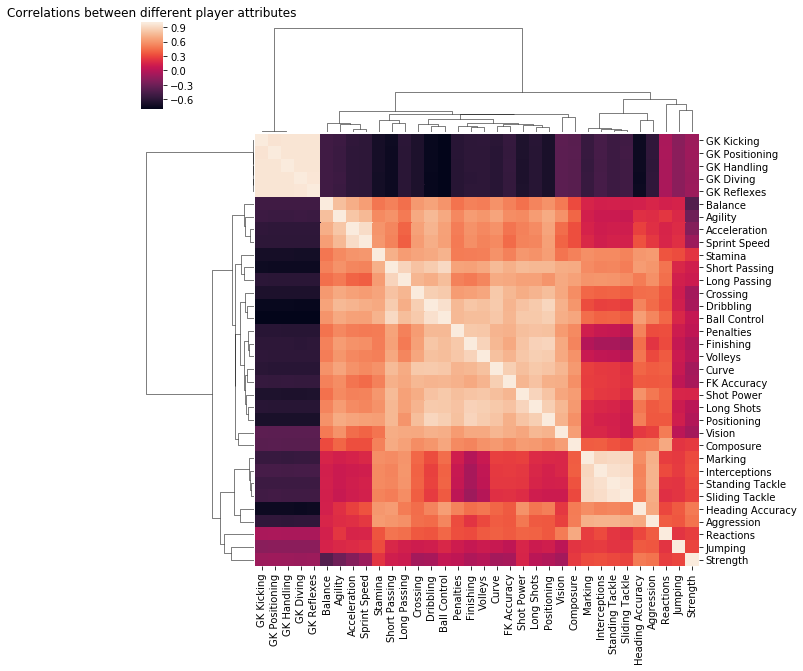

In [11]:
sns.clustermap(df_z.corr())
plt.title("Correlations between different player attributes")
plt.show()

As expected goal keeping attributes are negatively correlated to outfield attributes.

Interestingly, the cluster map has identified the three major types of players, goalkeepers defenders and attacking players. Investigating the clusters more closely confirms this assumption as the goal keeping (GK kicking,GK Handling etc.), attacking (Acceleration, Finishing, Volleys, Sprint speed etc.) and defending (Sliding tackle, strength, marking etc.) clusters contain the expected attributes.

## Kmeans clustering

Kmeans is an unsupervised learning technique which groups datapoints with similar properties together by measuring the 'distance' between each datapoint.





In [12]:
from sklearn.cluster import KMeans

distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    distances.append(km.inertia_)

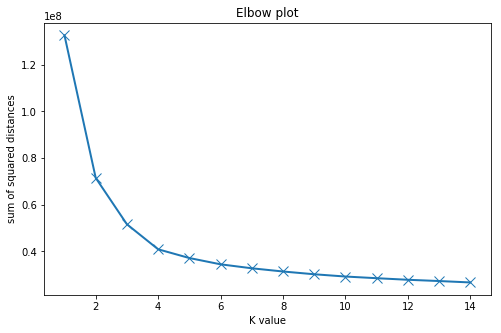

In [13]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,15),distances,marker='x',linewidth=2,markersize=10)
plt.title('Elbow plot')
plt.xlabel('K value')
plt.ylabel('sum of squared distances')
plt.show()

The optimal k value for the data appears to be k=4. This might be expected as traditionally there are four main types of playing position: striker; midfielder; defender and goal keeper.

In [14]:
km = KMeans(n_clusters=4,random_state=0)
km = km.fit(df_z)
labels = km.labels_

## Dimensionality reduction

__PCA analysis__

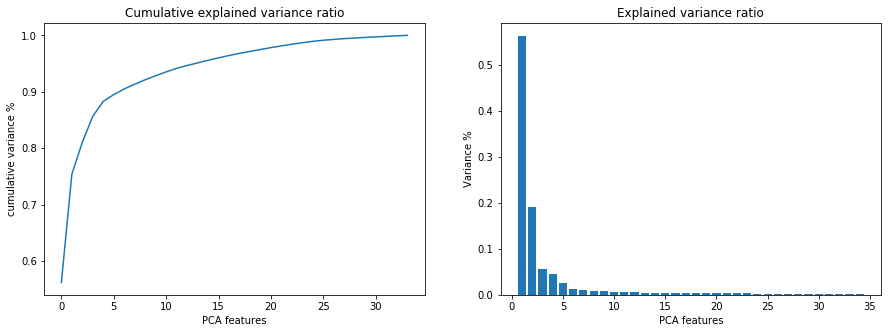

In [15]:
from sklearn.decomposition import PCA

pca = PCA()
principalComponents = pca.fit_transform(df)


features = range(1,pca.n_components_+1)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax1.set_xlabel('PCA features')
ax1.set_ylabel('cumulative variance %')
ax1.set_xticks(features)
ax1.set_title("Cumulative explained variance ratio")
ax1.set_xticks(range(0,35,5))

ax2.bar(features, pca.explained_variance_ratio_)
ax2.set_xlabel('PCA features')
ax2.set_ylabel('Variance %')
ax2.set_title("Explained variance ratio")
plt.show()

The variance tails off quickly after 2 PCA features, but about 90% of the variance is accounted for by about 10 of the features.

In [16]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

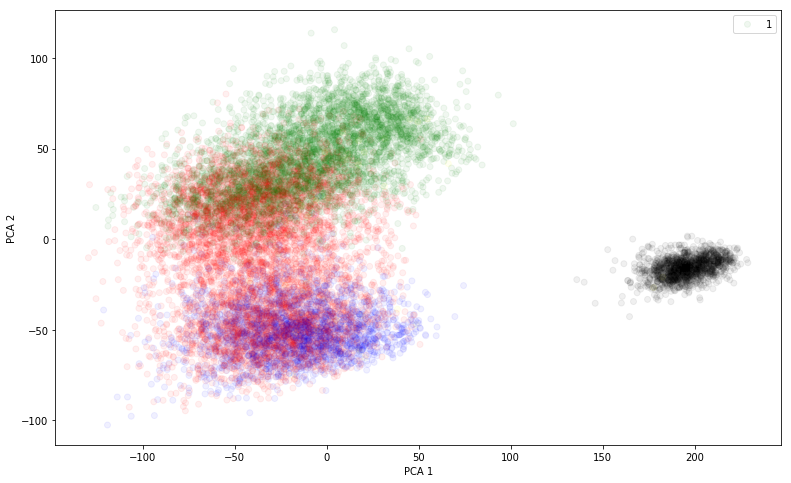

In [65]:
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}

plt.figure(figsize=(13,8))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.06, color=[ground_truth_colors[x] for x in labels])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend().set_visible(True)
plt.show()

__Using 3 PCA dimensions and plot in 3D__

In [67]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode()

data = go.Scatter3d(x=PCA_components[0], y=PCA_components[1], z=PCA_components[2],
                      mode='markers',
                      marker=dict(color=[ground_truth_colors[x] for x in labels],
                                  size=2,
                                 opacity=0.1),
                    text = raw_df['name'])

layout = dict(title="PCA(3) analysis")

fig = go.Figure(data=data,layout=layout)
iplot(fig)

__MDS analysis__

Alternative method to PCA. But is computationally expensive so only use a subset of the sample.

In [15]:
# from sklearn import manifold


# df_z_sample = df_z.sample(100)

# #create mds instance
# mds = manifold.MDS(n_components=2, random_state=5)

# mds_pos = mds.fit(df_z_sample).embedding_

In [16]:
#sample_labels = [labels[x] for x in df_z_sample.index]

In [17]:
# plt.figure(figsize=(12,7))
# plt.scatter(mds_pos[:, 0], mds_pos[:, 1], c=[colors[x] for x in sample_labels],alpha=0.6)
# plt.title('MDS')
# plt.show()

__t-SNE__

In [21]:
from sklearn.manifold import TSNE

df_z_sample = df.sample(5000)

tsne = TSNE(random_state=5)
tsne = tsne.fit_transform(df_z_sample)
#tsne =tsne.fit_transform(df_z)

In [24]:
sample_labels = [labels[x] for x in df_z_sample.index]

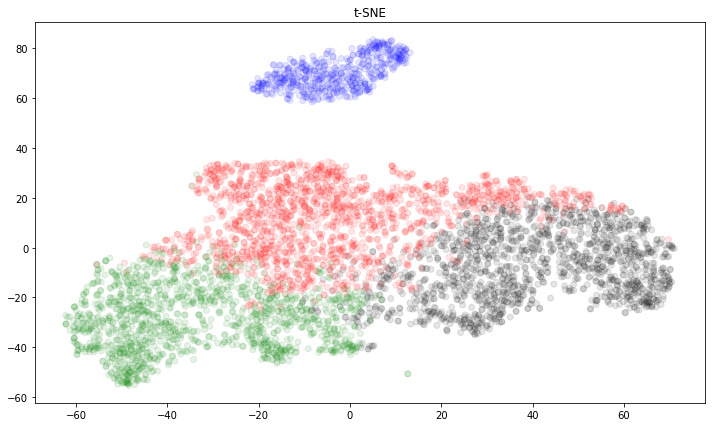

In [25]:
plt.figure(figsize=(12,7))
plt.scatter(tsne[:, 0], tsne[:, 1], c=[groud_truth_colors[x] for x in sample_labels],alpha=0.1)
#plt.scatter(tsne[:, 0], tsne[:, 1], c=[colors[x] for x in labels],alpha=0.1)
plt.title('t-SNE')
plt.show()

In [26]:
tsne.shape

(5000, 2)

In [28]:
data = go.Scatter3d(x=PCA_components[0], y=PCA_components[1], z=PCA_components[2],
                      mode='markers',
                      marker=dict(color=[colors[x] for x in sample_labels],
                                  size=2,
                                 opacity=0.1))
                    #text = df['name'])

layout = dict(title="PCA(3) analysis")

fig = go.Figure(data=data,layout=layout)
iplot(fig)

## DBSCAN

In [72]:
from sklearn.cluster import DBSCAN


# cluster the data into five clusters
dbscan = DBSCAN(eps=1, min_samples = 35)
db = dbscan.fit(df_mm)

labels = db.labels_ 
pd.DataFrame(labels)[0].value_counts()

 0    18849
 1     2159
-1        1
Name: 0, dtype: int64

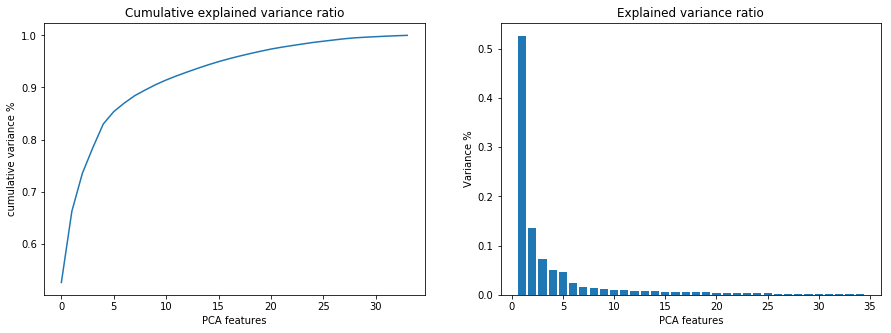

In [73]:
from sklearn.decomposition import PCA

pca = PCA()
principalComponents = pca.fit_transform(df_z)


features = range(1,pca.n_components_+1)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax1.set_xlabel('PCA features')
ax1.set_ylabel('cumulative variance %')
ax1.set_xticks(features)
ax1.set_title("Cumulative explained variance ratio")
ax1.set_xticks(range(0,35,5))

ax2.bar(features, pca.explained_variance_ratio_)
ax2.set_xlabel('PCA features')
ax2.set_ylabel('Variance %')
ax2.set_title("Explained variance ratio")
plt.show()

In [74]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)



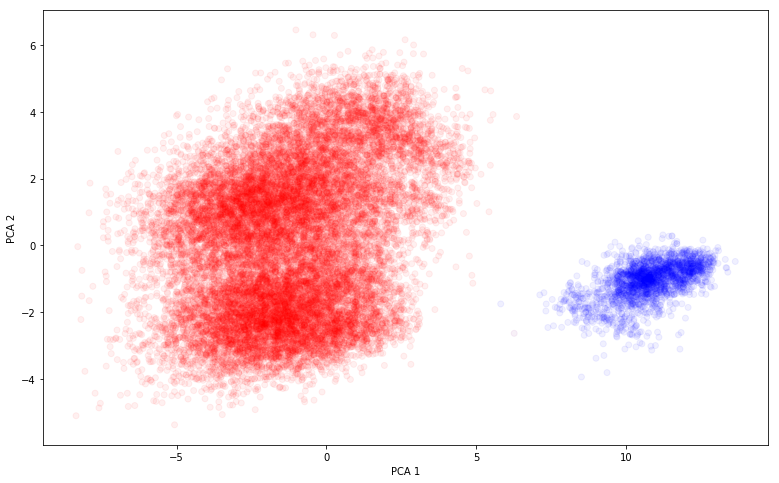

In [75]:
colors = {-1:'purple',0:'red', 1:'blue', 2:'green', 3:'black'}

plt.figure(figsize=(13,8))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.06, color=[colors[x] for x in labels])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()